# Lenet5 모델 (채널X)

In [22]:
# 웹 서버 -- 추론 서버
# 1. 웹 서버에서 이미지 캡쳐
# 2. 주소를 통해 추론 서버로 다운로드
# 3. 추론
#   1) 128,128,3 (기본 width,height,channel 순) PIL or opencv 활용
#   2) resize (이미지 축소 32,32) => PIL or opencv 활용
#   3) 3채널 -> 1채널 (컬러 -> 흑백)
#   4) (32,32,1) -> (1,32,32,1) 채널 추가
#   5) (1,1,32,32)
# 4. 추론 결과 전달


# 비전은 Pytorch ==> torchvision이 편리함

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets
import torchvision.transforms as transforms

In [4]:
from torchvision.transforms.transforms import ToTensor
# 데이터 전처리
data_transform = transforms.Compose(

    [
    # Pytorch에서는 텐서로 바꾸어주어야함
    # 이미 텐서이면 오류
    transforms.ToTensor(),

    # 32,32fh resize
    transforms.Resize(32),

    # 정규화
    transforms.Normalize((0.5,),(1.0,))

    ]
)

# 여기까지는 transform이 적용 안된 것
# Loader 통과할 때 적용
train_data = datasets.MNIST(root='/content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/',download=True,train=True,transform=data_transform)
test_data = datasets.MNIST(root='/content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/',download=True,train=False,transform=data_transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 87116805.23it/s]


Extracting /content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60116969.64it/s]


Extracting /content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21464924.65it/s]


Extracting /content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4542329.22it/s]


Extracting /content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/MNIST/raw



In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_lenet/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=warn)
               Normalize(mean=(0.5,), std=(1.0,))
           )

In [21]:
type(train_data.data[0])

torch.Tensor

In [7]:
train_data.data[0].size()

torch.Size([28, 28])

In [8]:
test_data.data[0].size()

torch.Size([28, 28])

In [10]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [11]:
from torch.utils.data.dataloader import DataLoader

# Loader에 들어가면 Transform 적용됀
train_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_loader = DataLoader(test_data,batch_size=32)

In [12]:
# Lenet : conv layer 3개 , Fully Connected 2개
# https://bskyvision.com/entry/CNN-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98%EB%93%A4-LeNet-5%EC%9D%98-%EA%B5%AC%EC%A1%B0

class Net(nn.Module):

  def __init__(self):
    super(Net,self).__init__()

    # 갯수를 계산해서 맞추어 주어야함
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1)
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1)
    self.conv3 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5,stride=1)
    self.fc1 = nn.Linear(in_features=120,out_features=84)
    self.fc2 = nn.Linear(in_features=84,out_features=10)

  def forward(self,x):

    # 신경망 통과
    x = self.conv1(x)
    # nn.ReLU 들은 nn 객체로 만들어 사용
    # F. 는 바로 사용
    x = F.tanh(x)
    x = F.max_pool2d(x,2,2)

    x = self.conv2(x)
    x = F.tanh(x)
    x = F.max_pool2d(x,2,2)

    x = self.conv3(x)
    x = F.tanh(x)
    # 마지막에 펼침
    x = x.view(-1,120)

    x = self.fc1(x)
    x = F.tanh(x)
    x = self.fc2(x)
    x = F.tanh(x)

    return x

In [13]:
model = Net()
model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
X_train , y_train = train_data.data, train_data.targets
X_test , y_test = test_data.data, test_data.targets

X_train.shape , y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [17]:
X_train = X_train.unsqueeze(1)
X_train.shape

torch.Size([60000, 1, 28, 28])

In [18]:
X_test = X_test.unsqueeze(1)
X_test.shape

torch.Size([10000, 1, 28, 28])

tensor(5)


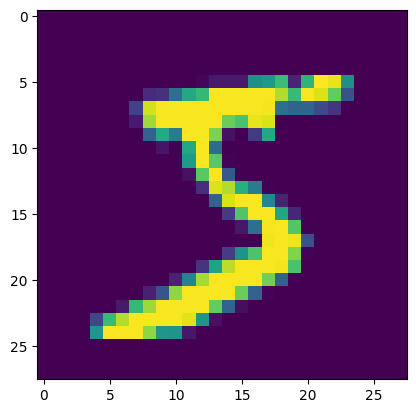

In [20]:
import matplotlib.pyplot as plt

def show(img):
  temp_img = img.numpy()
  # 순서를 바꿔라
  temp_img_tr = temp_img.transpose((1,2,0))
  plt.imshow(temp_img_tr)
  print(y_train[0])

show(X_train[0])

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

optim = Adam(model.parameters(),lr=1e-3)

for epoch in range(10):
  for data,label in train_loader:
    optim.zero_grad()
    pred = model(data.to(device))
    loss = nn.CrossEntropyLoss()(pred,label.to(device))
    loss.backward()
    optim.step()
  print(f'{epoch+1} loss : {loss.item()}')

1 loss : 0.8027721047401428
2 loss : 0.8027010560035706
3 loss : 0.8399378061294556
4 loss : 0.8549843430519104
5 loss : 0.8017281293869019
6 loss : 0.8062971830368042
7 loss : 0.8146271705627441
8 loss : 0.8116360306739807
9 loss : 0.8071960806846619
10 loss : 0.7966869473457336


In [7]:
infer_transform = transforms.Compose(

    [
    # Pytorch에서는 텐서로 바꾸어주어야함
    # 이미 텐서이면 오류
    transforms.ToTensor(),

    # 추론할때 RGB사진일 수 있어 GrayScale로 바꿔주는 함수 적용
    transforms.Grayscale(),
    # 32,32fh resize
    transforms.Resize(32),

    # 정규화
    transforms.Normalize((0.5,),(1.0,))

    ]
)

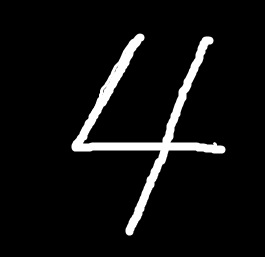

In [2]:
import cv2
from google.colab.patches import cv2_imshow

path = '/content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_number4/pytorch_num4.jpg'

img = cv2.imread(path)
cv2_imshow(img)

In [ ]:
# trasform(numpy형) : data.numpy()로 하거나 ToTensor() 제거
# 28,28 => 1,32,32 : 채널추가해주고 Resize도 해줌

# from PIL import Image

# # 현재 PIL 타입
# img = Image.open(path)
# # numpy()로
# img = np.array(img)
# img

# jpg 3채널
# png 4채널

In [8]:
img = infer_transform(img)
img

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         ...,
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
         [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]])

In [9]:
img.size()

torch.Size([1, 32, 32])

# 외부 이미지 transform으로 전처리

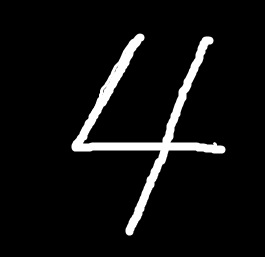

In [36]:
import cv2
from google.colab.patches import cv2_imshow

path = '/content/drive/MyDrive/메타버스_아카데미_2기/딥러닝/6월/pytorch_number4/pytorch_num4.jpg'

img2 = cv2.imread(path)
cv2_imshow(img2)

In [37]:
img2 = transforms.ToTensor()(img2)
img2 = transforms.Grayscale()(img2)
img2 = transforms.Resize(32)(img2)
img2 = transforms.Normalize((0.5,),(1.0,))(img2)


In [38]:
img2.size()

torch.Size([1, 32, 32])

In [ ]:
infer_transform = transforms.Compose(

    [
    # Pytorch에서는 텐서로 바꾸어주어야함
    # 이미 텐서이면 오류
    transforms.ToTensor(),

    # 추론할때 RGB사진일 수 있어 GrayScale로 바꿔주는 함수 적용
    transforms.Grayscale(),
    # 32,32fh resize
    transforms.Resize(32),

    # 정규화
    transforms.Normalize((0.5,),(1.0,))

    ]
)

# 텐서보드

In [39]:
%matplotlib inline
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [41]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()
writer

In [ ]:
# 학습할 때 writer.add_scalar

optim = Adam(model.parameters(),lr=1e-3)

for epoch in range(10):
  for data,label in train_loader:
    optim.zero_grad()
    pred = model(data.to(device))
    loss = nn.CrossEntropyLoss()(pred,label.to(device))
    writer.add_scalar("Loss/")
    loss.backward()
    optim.step()
  print(f'{epoch+1} loss : {loss.item()}')

In [ ]:
# 쓰기 종료
writer.close()

#
%load

# 크롬에서 텐서보드 안될 때
# 설정 - 서드 파티 쿠키 허용 체크